In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy

# FM을 위한 데이터셋 만들기

In [2]:
data_path = "/home/minsoo/Workspace/RecSys-study/data/kmrd/kmr_dataset/datafile/kmrd-small/"
df = pd.read_csv(data_path + 'rates.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)

In [3]:
train_df.head()

,user,movie,rate,time
135746,47200,10708,10,1443157320
92746,17241,10813,9,1569378300
96567,19461,10048,10,1246024800
29770,2354,10847,7,1162058640
2252,73,10912,8,1415827800


In [4]:
# 평점 이외의 데이터 불러오기
movies_df = pd.read_csv(data_path +'movies.txt', sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')
castings_df = pd.read_csv(data_path + 'castings.csv', encoding='utf-8')
countries_df = pd.read_csv(data_path + 'countries.csv', encoding='utf-8')
genres_df = pd.read_csv(data_path + 'genres.csv', encoding='utf-8')

# genre
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# castings
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# countries
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

print(movies_df.shape)
movies_df.head()

(999, 7)


,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국


In [5]:
# genre onehot vector
dummy_genres_df = movies_df['genres'].str.get_dummies(sep='/')
dummy_genres_df.head()

,SF,가족,공포,느와르,다큐멘터리,드라마,로맨스,멜로,모험,뮤지컬,...,범죄,서부,서사,스릴러,애니메이션,액션,에로,전쟁,코미디,판타지
movie,,,,,,,,,,,,,,,,,,,,,
10001,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10003,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10004,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
10005,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [6]:
dummy_grade_df = pd.get_dummies(movies_df['grade'], prefix='grade')
dummy_grade_df.head()

,grade_12세 관람가,grade_15세 관람가,grade_G,grade_NR,grade_PG,grade_PG-13,grade_R,grade_전체 관람가,grade_청소년 관람불가
movie,,,,,,,,,
10001,0,0,0,0,0,0,0,1,0
10002,1,0,0,0,0,0,0,0,0
10003,1,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,0,0,1,0
10005,0,0,0,0,1,0,0,0,0


In [7]:
train_df = train_df[:2000]
print(train_df.shape)

(2000, 4)


In [8]:
train_df.head()

,user,movie,rate,time
135746,47200,10708,10,1443157320
92746,17241,10813,9,1569378300
96567,19461,10048,10,1246024800
29770,2354,10847,7,1162058640
2252,73,10912,8,1415827800


In [9]:
X_train = pd.concat([pd.get_dummies(train_df['user'], prefix='user'),
           pd.get_dummies(train_df['movie'], prefix='movie'),
           train_df['movie'].apply(lambda x: dummy_genres_df.loc[x]),
           train_df['movie'].apply(lambda x: dummy_grade_df.loc[x])], axis=1)

In [10]:
print(X_train.shape)
X_train.head()

(2000, 2134)


,user_0,user_4,user_15,user_17,user_20,user_25,user_29,user_32,user_37,user_42,...,판타지,grade_12세 관람가,grade_15세 관람가,grade_G,grade_NR,grade_PG,grade_PG-13,grade_R,grade_전체 관람가,grade_청소년 관람불가
135746,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
92746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96567,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
29770,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2252,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [11]:
# 10만 1로 주고, 나머지는 -1로 binary 지정
y_train = train_df['rate'].apply(lambda x: 1 if x > 9 else -1).values

In [12]:
# 0이 아닌 데이터 위치 확인하기위해 csr matrix 활용
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

In [13]:
X_train_sparse

# https://rfriend.tistory.com/551

<2000x2134 sparse matrix of type '<class 'numpy.int64'>'
	with 11375 stored elements in Compressed Sparse Row format>

# 모델 훈련

In [14]:
config = {
    "epochs": 10,
    "n_factors": 10,
    "learning_rate": 0.1,
    "regularize_W": 0.01,
    "regularize_V": 0.01
}

In [15]:
module_path = '/home/minsoo/Workspace/RecSys-study/'
import sys
sys.path.append(module_path)

from src.model.FM import FactorizationMachine

In [16]:
fm = FactorizationMachine(X_train_sparse, y_train, config)

In [17]:
epoch_loss = fm.fit()

[epoch: 1], loss: 2.5970278874103254
[epoch: 2], loss: 1.1023901869755395
[epoch: 3], loss: 0.6411871346861865
[epoch: 4], loss: 0.389005182782904
[epoch: 5], loss: 0.27231194587407787
[epoch: 6], loss: 0.19482748709600062
[epoch: 7], loss: 0.14191348471688175
[epoch: 8], loss: 0.11063813290111091
[epoch: 9], loss: 0.08831638290359024
[epoch: 10], loss: 0.07361784651913028


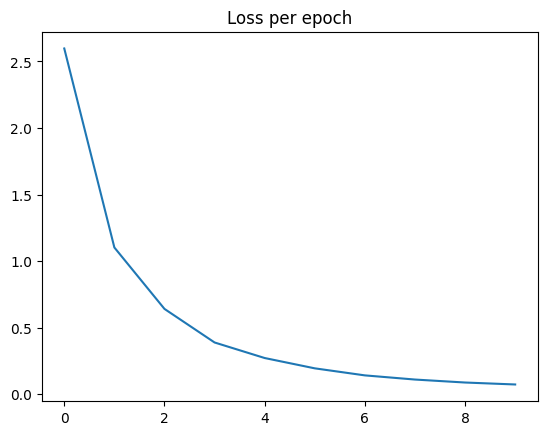

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.title('Loss per epoch')
plt.show()